In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge

sys.path.append(r'C:\Users\DerDo\Desktop\fantasy_basketball_project')
from functions import *

In [2]:
data = get_player_data('sabondo01', '2025')

season_data = data[1]
missed_data = data[0]

In [5]:
models = create_models(season_data)

C:\Users\DerDo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.167e+05, tolerance: 1.026e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\DerDo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+00, tolerance: 1.021e+00
  model = cd_fast.enet_coordinate_descent(


In [9]:
### make the alpha model for each model equal to the correct alpha

In [22]:
curr_team = season_data['Team'][0]

nba_teams = [
    "ATL", "BOS", "BRK", "CHI", "CLE", "DAL", "DEN", "DET", 
    "GSW", "HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", 
    "MIN", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", 
    "SAC", "SAS", "TOR", "UTA", "WAS", "CHO"
]

nba_teams.remove(curr_team)

to_remove = [
    'Date', 'Opp', 'URL', 'Player_NAME', 'double_double', 'triple_double', 
    'Team', 'fantasy_score', 'Result' # result is classification
]

to_remove = to_remove + nba_teams

features_to_model = season_data.drop(columns=to_remove).columns.to_list()

models = []
scores = []
alphas = []
for feature in features_to_model:
    X = season_data[features_to_model].drop(columns=f'{feature}').values
    y = season_data[f'{feature}'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    linreg = LinearRegression()
    linreg.fit(X_train_scaled, y_train)

    linreg_score = linreg.score(X_test_scaled, y_test) 

    alpha_vals = [0.1, 1.0, 10.0, 100.0, 1000.0]

    ridge_scores = []
    for alpha in alpha_vals:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)
        ridge_scores.append(ridge.score(X_test_scaled, y_test))

    lasso_scores = []
    for alpha in alpha_vals:
        ridge = Lasso(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)
        lasso_scores.append(ridge.score(X_test_scaled, y_test))

    scores_list = [[LinearRegression(), np.nan, linreg_score]] + \
    [[Ridge(), alpha, score] for alpha, score in zip(alpha_vals, ridge_scores)] + \
    [[Lasso(), alpha, score] for alpha, score in zip(alpha_vals, lasso_scores)]

    model_selection_df = (
        pd
        .DataFrame(scores_list, columns=['model', 'alpha', 'score'])
        .sort_values('score', ascending=False)
    )

    model_selection_df = model_selection_df[model_selection_df['score'] != 1]

    final_model_data = model_selection_df.iloc[0]
    final_model = final_model_data['model']
    final_alpha = final_model_data['alpha']

    if type(final_alpha) == float:
        final_model.set_params(alpha=final_alpha)

    final_model.fit(X_train_scaled, y_train)

    models.append(final_model)
    scores.append(final_model_data['score'])
    alphas.append(final_alpha)

final_models = pd.DataFrame({
    'Feature': features_to_model,
    'Model': models,
    'Score': scores,
    'Alphas': alphas
})

final_models

C:\Users\DerDo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.000e+05, tolerance: 4.123e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\DerDo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.987e+03, tolerance: 4.123e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\DerDo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

,Feature,Model,Score,Alphas
0,MP,Lasso(),0.825013,1.0
1,FG,Ridge(),0.999691,0.1
2,FGA,Ridge(),0.999902,0.1
3,FG%,Ridge(),0.994891,0.1
4,3P,Ridge(),0.994407,0.1
5,3PA,Ridge(),0.988988,0.1
6,3P%,Ridge(),0.741835,1.0
7,2P,Ridge(),0.999428,0.1
8,2PA,Ridge(),0.999747,0.1
9,2P%,Ridge(),0.969937,0.1


From chatgpt:

"So, based on publicly available league-average stats and your scoring model, 
the typical NBA starter in the 2024–25 season likely averaged around 25.5 
fantasy points per game.

If you have data on specific starters’ per-game stats, you could compute their 
individual fantasy scores more precisely!"

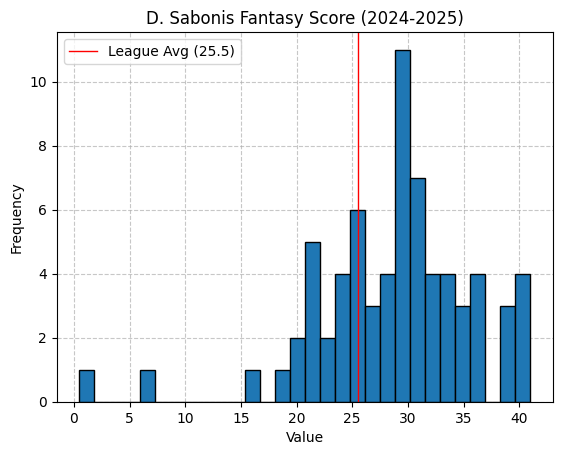

In [3]:
# Create a figure and an Axes object
fig, ax = plt.subplots()

# Plot the histogram
ax.hist(season_data['fantasy_score'], bins=30, edgecolor='black', zorder=2) # Give the histogram a zorder > 0

# Add the grid with a lower zorder to place it behind the histogram
ax.grid(True, linestyle='--', alpha=0.7, zorder=0)

# Add a vertical line at 25.5
ax.axvline(25.5, color='red', linestyle='-', linewidth=1, label="League Avg (25.5)")

# Add labels and title for clarity
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("D. Sabonis Fantasy Score (2024-2025)")

# Add legend
ax.legend()

# Display the plot
plt.show()

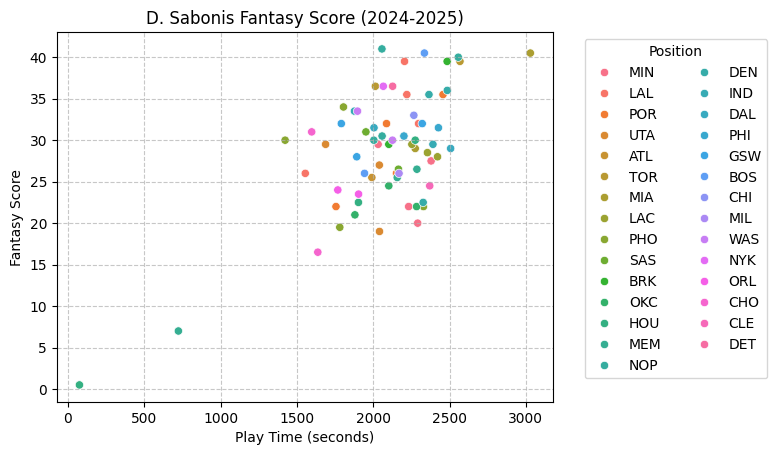

In [4]:
fig, ax = plt.subplots()

sns.scatterplot(data=season_data, x='MP', y='fantasy_score', hue='Opp')

# Add the grid with a lower zorder to place it behind the histogram
ax.grid(True, linestyle='--', alpha=0.7, zorder=0)

# Add labels and title for clarity
ax.set_ylabel("Fantasy Score")
ax.set_xlabel("Play Time (seconds)")
ax.set_title("D. Sabonis Fantasy Score (2024-2025)")

# Add legend
ax.legend(title="Position", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2)

plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [ ]:
def model_feature(feature):
    X = season_data.drop(columns=[
        'Date', 'Opp', f'{feature}', 'URL', 'Player_NAME', 'TRB', 'AST', 'PTS', 
        'TOV', 'STL', 'BLK', 'double_double', 'triple_double'
    ]).values
    y = season_data[[f'{feature}']].values

    scaler = StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    linreg = LinearRegression()
    linreg.fit(X_train_scaled, y_train)

    linreg_score = linreg.score(X_test_scaled, y_test) # 0.47934832060435195

    alpha_vals = [0.1, 1.0, 10.0, 100.0, 1000.0]

    ridge_scores = []
    for alpha in alpha_vals:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)
        ridge_scores.append(ridge.score(X_test_scaled, y_test))

    lasso_scores = []
    for alpha in alpha_vals:
        ridge = Lasso(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)
        lasso_scores.append(ridge.score(X_test_scaled, y_test))

    scores_list = [[LinearRegression(), np.nan, linreg_score]] + \
    [[Ridge(), alpha, score] for alpha, score in zip(alpha_vals, ridge_scores)] + \
    [[Lasso(), alpha, score] for alpha, score in zip(alpha_vals, lasso_scores)]

    model_selection_df = (
        pd
        .DataFrame(scores_list, columns=['model', 'alpha', 'score'])
        .sort_values('score', ascending=False)
    )

    final_model_data = model_selection_df.iloc[0]
    final_model = final_model_data['model']
    final_alpha = final_model_data['alpha']

    if type(final_alpha) == float:
        final_model.set_params(alpha=final_alpha)

    final_model.fit(X_train_scaled, y_train)

    print(f'Modeling Data for: {feature}')

    return final_model, final_model_data['score']

In [7]:
model_feature('fantasy_score')

Modeling Data for: fantasy_score


,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [8]:
season_data.columns

Index(['Date', 'Opp', 'Result', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-', 'Team Score',
       'Opp Score', 'Percent Score', 'URL', 'Player_NAME', 'ATL', 'BOS', 'BRK',
       'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL',
       'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO',
       'POR', 'SAS', 'TOR', 'UTA', 'WAS', 'CHO', 'double_double',
       'triple_double', 'fantasy_score'],
      dtype='object')

In [ ]:
features_to_model = season_data.drop(columns=[
    'Date', 'Opp', 'URL', 'Player_NAME', 'TRB', 'AST', 'PTS', 
    'TOV', 'STL', 'BLK', 'double_double', 'triple_double', 'ATL', 'BOS', 'BRK',
       'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL',
       'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO',
       'POR', 'SAS', 'TOR', 'UTA', 'WAS', 'CHO', 'fantasy_score'
]).columns.to_list()

models = {}
for feature in features_to_model:
    model = model_feature(feature)
    models[feature] = model[0]
    models[f'{feature} score'] = model[1]

Modeling Data for: Result
Modeling Data for: MP
Modeling Data for: FG
Modeling Data for: FGA
Modeling Data for: FG%
Modeling Data for: 3P
Modeling Data for: 3PA
Modeling Data for: 3P%
Modeling Data for: 2P
Modeling Data for: 2PA
Modeling Data for: 2P%
Modeling Data for: eFG%
Modeling Data for: FT


C:\Users\DerDo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.467e+05, tolerance: 9.271e+02
  model = cd_fast.enet_coordinate_descent(


Modeling Data for: FTA
Modeling Data for: FT%
Modeling Data for: ORB
Modeling Data for: DRB
Modeling Data for: PF
Modeling Data for: GmSc
Modeling Data for: +/-
Modeling Data for: Team Score
Modeling Data for: Opp Score
Modeling Data for: Percent Score
Modeling Data for: fantasy_score


In [ ]:
features_to_model.pop()

'fantasy_score'

In [31]:
coefs = models['fantasy_score'].coef_
plotting = {'features': features_to_model, 'coef': coefs}

len(coefs)
len(features_to_model)

23

In [18]:
models

{'Result': Lasso(),
 'Result score': np.float64(0.4216030601407259),
 'MP': Ridge(),
 'MP score': np.float64(-0.649443338276376),
 'FG': LinearRegression(),
 'FG score': np.float64(1.0),
 'FGA': LinearRegression(),
 'FGA score': np.float64(1.0),
 'FG%': LinearRegression(),
 'FG% score': np.float64(0.9564459688379208),
 '3P': LinearRegression(),
 '3P score': np.float64(1.0),
 '3PA': LinearRegression(),
 '3PA score': np.float64(1.0),
 '3P%': Ridge(),
 '3P% score': np.float64(0.6411593718578078),
 '2P': LinearRegression(),
 '2P score': np.float64(1.0),
 '2PA': LinearRegression(),
 '2PA score': np.float64(1.0),
 '2P%': Ridge(),
 '2P% score': np.float64(0.7442053183139079),
 'eFG%': Ridge(),
 'eFG% score': np.float64(0.9587280713260773),
 'FT': Lasso(),
 'FT score': np.float64(0.9256474163366317),
 'FTA': Lasso(),
 'FTA score': np.float64(0.8398648162864656),
 'FT%': Lasso(),
 'FT% score': np.float64(-0.12484408940935121),
 'ORB': Ridge(),
 'ORB score': np.float64(0.0818763420018791),
 'DRB

In [35]:
features_to_model = season_data.drop(columns=[
    'Date', 'Opp', 'URL', 'Player_NAME', 'TRB', 'AST', 'PTS', 
    'TOV', 'STL', 'BLK', 'double_double', 'triple_double', 'ATL', 'BOS', 'BRK',
       'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL',
       'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO',
       'POR', 'SAS', 'TOR', 'UTA', 'WAS', 'CHO', 'fantasy_score'
]).columns.to_list()

for feature in features_to_model:
    X = season_data.drop(columns=[
        'Date', 'Opp', f'{feature}', 'URL', 'Player_NAME', 'TRB', 'AST', 'PTS', 
        'TOV', 'STL', 'BLK', 'double_double', 'triple_double', 'fantasy_score'
    ]).values
    y = season_data[[f'{feature}']].values



In [ ]:
sea